In [1]:
!unzip archive.zip -d data # unzip the downloaded dataset

Archive:  archive.zip
  inflating: data/README             
  inflating: data/s1/1.pgm           
  inflating: data/s1/10.pgm          
  inflating: data/s1/2.pgm           
  inflating: data/s1/3.pgm           
  inflating: data/s1/4.pgm           
  inflating: data/s1/5.pgm           
  inflating: data/s1/6.pgm           
  inflating: data/s1/7.pgm           
  inflating: data/s1/8.pgm           
  inflating: data/s1/9.pgm           
  inflating: data/s10/1.pgm          
  inflating: data/s10/10.pgm         
  inflating: data/s10/2.pgm          
  inflating: data/s10/3.pgm          
  inflating: data/s10/4.pgm          
  inflating: data/s10/5.pgm          
  inflating: data/s10/6.pgm          
  inflating: data/s10/7.pgm          
  inflating: data/s10/8.pgm          
  inflating: data/s10/9.pgm          
  inflating: data/s11/1.pgm          
  inflating: data/s11/10.pgm         
  inflating: data/s11/2.pgm          
  inflating: data/s11/3.pgm          
  inflating: data/s11/4.pgm 

In [109]:
import os
import shutil
import random
import numpy as np
import cv2
from PIL import Image


import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D

from tensorflow.keras.utils import plot_model

from tensorflow.keras.saving import save_model
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing import image

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc

print(tf.version.VERSION)


2.12.0


In [9]:
# set the paths to the original and new data directories
original_data_dir = '/content/data'
train_dir = '/content/process_data/train'
valid_dir = '/content/process_data/valid'

# Define paths
original_dataset_path = '/content/data'
train_dataset_path = '/content/process_data/train'
validation_dataset_path = '/path/to/validation_dataset'

# Create train and validation folders
os.makedirs(train_dataset_path, exist_ok=True)
os.makedirs(validation_dataset_path, exist_ok=True)

# Loop through original dataset folders
for folder_name in os.listdir(original_dataset_path):
    folder_path = os.path.join(original_dataset_path, folder_name)
    if os.path.isdir(folder_path):
        # Create corresponding folders in train and validation datasets
        train_folder_path = os.path.join(train_dataset_path, folder_name)
        validation_folder_path = os.path.join(validation_dataset_path, folder_name)
        os.makedirs(train_folder_path, exist_ok=True)
        os.makedirs(validation_folder_path, exist_ok=True)
        
        # Loop through images in the original folder
        for i in range(1, 11):
            image_path = os.path.join(folder_path, f'{i}.pgm')
            if os.path.isfile(image_path):
                # Load image using PIL
                img = Image.open(image_path).convert('RGB')
                
                # Split into train and validation
                if i <= 7:
                    # Save to train folder with original name, but in PNG format
                    img.save(os.path.join(train_folder_path, f'{i}.png'))
                else:
                    # Save to validation folder with original name, but in PNG format
                    img.save(os.path.join(validation_folder_path, f'{i}.png'))

In [4]:
!zip -r processed_data.zip /content/process_data

  adding: content/process_data/ (stored 0%)
  adding: content/process_data/train/ (stored 0%)
  adding: content/process_data/train/s15/ (stored 0%)
  adding: content/process_data/train/s15/7.png (stored 0%)
  adding: content/process_data/train/s15/4.png (stored 0%)
  adding: content/process_data/train/s15/5.png (stored 0%)
  adding: content/process_data/train/s15/3.png (stored 0%)
  adding: content/process_data/train/s15/6.png (stored 0%)
  adding: content/process_data/train/s15/2.png (stored 0%)
  adding: content/process_data/train/s15/1.png (stored 0%)
  adding: content/process_data/train/s23/ (stored 0%)
  adding: content/process_data/train/s23/7.png (stored 0%)
  adding: content/process_data/train/s23/4.png (stored 0%)
  adding: content/process_data/train/s23/5.png (stored 0%)
  adding: content/process_data/train/s23/3.png (stored 0%)
  adding: content/process_data/train/s23/6.png (stored 0%)
  adding: content/process_data/train/s23/2.png (stored 0%)
  adding: content/process_data/

In [10]:

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # rotate images by up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # shift images vertically by up to 20% of the image height
    shear_range=0.2,  # apply shear transformation with a shear angle of up to 20 degrees
    zoom_range=0.2,  # apply zoom transformation by up to 20%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # fill any gaps created by the above transformations with the nearest pixel
)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')


Found 280 images belonging to 40 classes.
Found 120 images belonging to 40 classes.


In [5]:

# Load VGG19 model without top layers
base_model = VGG19(weights='imagenet', include_top=False)

# Add top layers
x = base_model.output
x1 = GlobalAveragePooling2D()(x)
x2 = Dense(4096, activation='relu')(x1) # Keep the fully connected layer with 4096 units
x3 = Dense(4096, activation='relu')(x2) # Keep the fully connected layer with 4096 units
predictions = Dense(40, activation='softmax')(x3) # Change to 40 units for 40-class classifier

# Create a new model with the added top layers
model_1 = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_1.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [7]:

# Train the model
history_1 = model_1.fit(
    train_generator,
    epochs=20,  # specify the number of epochs for training
    validation_data=val_generator
)


Epoch 1/20
5/5 [==============================] - 361s 77s/step - loss: 4.7425 - accuracy: 0.0071 - val_loss: 3.7313 - val_accuracy: 0.0333
Epoch 2/20
5/5 [==============================] - 311s 65s/step - loss: 3.7373 - accuracy: 0.0214 - val_loss: 3.6872 - val_accuracy: 0.0333
Epoch 3/20
5/5 [==============================] - 359s 77s/step - loss: 3.6980 - accuracy: 0.0286 - val_loss: 3.6717 - val_accuracy: 0.0667
Epoch 4/20
5/5 [==============================] - 358s 77s/step - loss: 3.6744 - accuracy: 0.0429 - val_loss: 3.6464 - val_accuracy: 0.0500
Epoch 5/20
5/5 [==============================] - 357s 77s/step - loss: 3.6419 - accuracy: 0.0643 - val_loss: 3.6068 - val_accuracy: 0.0833
Epoch 6/20
5/5 [==============================] - 357s 85s/step - loss: 3.5917 - accuracy: 0.0786 - val_loss: 3.5225 - val_accuracy: 0.1000
Epoch 7/20
5/5 [==============================] - 357s 76s/step - loss: 3.4923 - accuracy: 0.0643 - val_loss: 3.4137 - val_accuracy: 0.0833
Epoch 8/20
5/5 [====

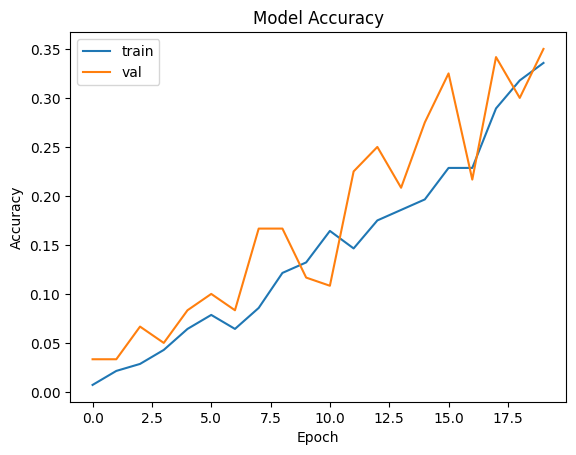

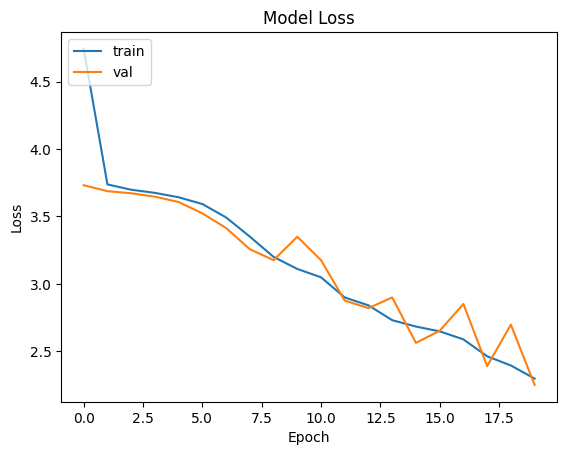

In [8]:

# Plot the training and validation accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [9]:

# Train the model
history_2 = model_1.fit(
    train_generator,
    epochs=10,  # specify the number of epochs for training
    validation_data=val_generator
)


Epoch 1/10
5/5 [==============================] - 304s 64s/step - loss: 2.2405 - accuracy: 0.3393 - val_loss: 2.3305 - val_accuracy: 0.3833
Epoch 2/10
5/5 [==============================] - 357s 76s/step - loss: 2.2439 - accuracy: 0.3214 - val_loss: 2.3837 - val_accuracy: 0.3583
Epoch 3/10
5/5 [==============================] - 357s 77s/step - loss: 2.1299 - accuracy: 0.4000 - val_loss: 2.2518 - val_accuracy: 0.4500
Epoch 4/10
5/5 [==============================] - 355s 76s/step - loss: 2.0231 - accuracy: 0.3964 - val_loss: 2.1112 - val_accuracy: 0.4167
Epoch 5/10
5/5 [==============================] - 357s 77s/step - loss: 1.9979 - accuracy: 0.3929 - val_loss: 2.1440 - val_accuracy: 0.4583
Epoch 6/10
5/5 [==============================] - 357s 77s/step - loss: 1.8919 - accuracy: 0.4179 - val_loss: 2.0270 - val_accuracy: 0.4333
Epoch 7/10
5/5 [==============================] - 304s 71s/step - loss: 1.8603 - accuracy: 0.4500 - val_loss: 1.9656 - val_accuracy: 0.4917
Epoch 8/10
5/5 [====

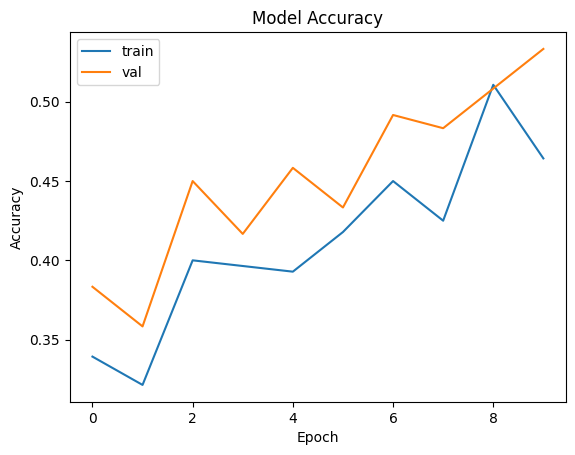

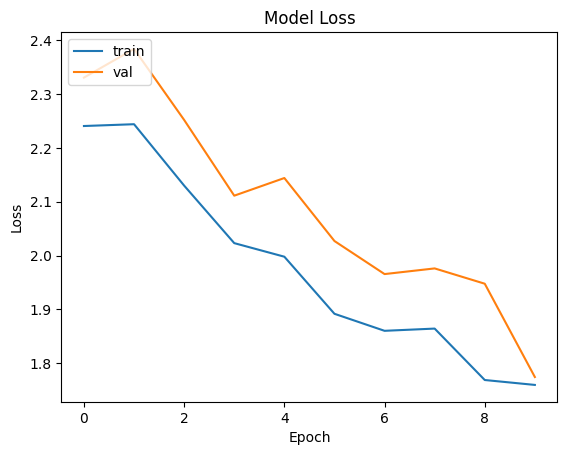

In [10]:

# Plot the training and validation accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [11]:
model_1.save_weights('model_1_weights_updated.h5')

In [12]:

# Train the model
history_3 = model_1.fit(
    train_generator,
    epochs=5,  # specify the number of epochs for training
    validation_data=val_generator
)


Epoch 1/5
5/5 [==============================] - 365s 77s/step - loss: 1.8215 - accuracy: 0.4464 - val_loss: 1.9011 - val_accuracy: 0.5750
Epoch 2/5
5/5 [==============================] - 304s 64s/step - loss: 1.6909 - accuracy: 0.4786 - val_loss: 1.6031 - val_accuracy: 0.6250
Epoch 3/5
5/5 [==============================] - 304s 64s/step - loss: 1.6931 - accuracy: 0.5036 - val_loss: 1.6536 - val_accuracy: 0.6000
Epoch 4/5
5/5 [==============================] - 357s 84s/step - loss: 1.6081 - accuracy: 0.4857 - val_loss: 1.6541 - val_accuracy: 0.6000
Epoch 5/5
5/5 [==============================] - 305s 64s/step - loss: 1.5638 - accuracy: 0.5214 - val_loss: 1.6691 - val_accuracy: 0.5750


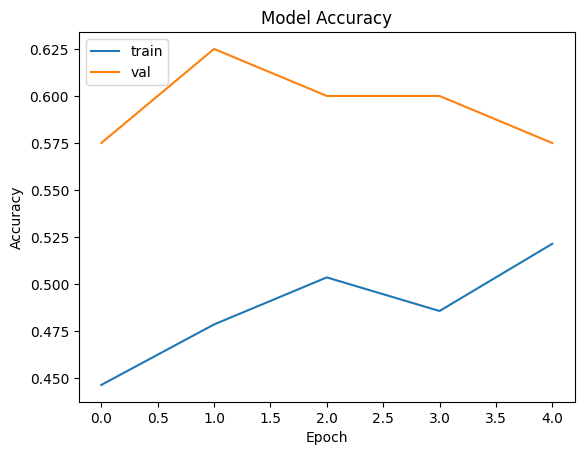

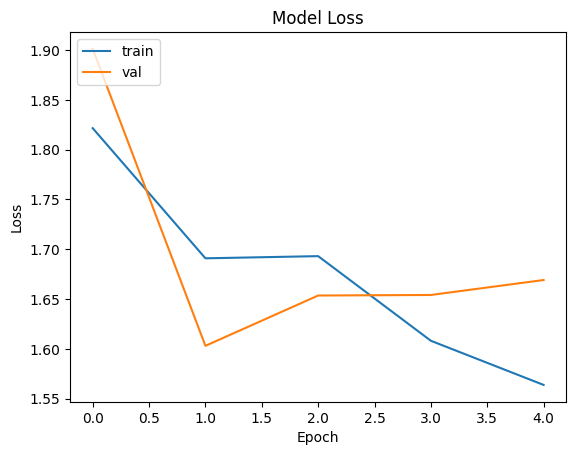

In [13]:

# Plot the training and validation accuracy
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [25]:
model_1.save_weights('model_1_weights_updated1.h5')

In [26]:

# Train the model
history_4 = model_1.fit(
    train_generator,
    epochs=5,  # specify the number of epochs for training
    validation_data=val_generator
)


Epoch 1/5
5/5 [==============================] - 368s 79s/step - loss: 1.5524 - accuracy: 0.5679 - val_loss: 1.6536 - val_accuracy: 0.5500
Epoch 2/5
5/5 [==============================] - 362s 78s/step - loss: 1.4531 - accuracy: 0.5714 - val_loss: 1.7133 - val_accuracy: 0.5500
Epoch 3/5
5/5 [==============================] - 364s 79s/step - loss: 1.4310 - accuracy: 0.5821 - val_loss: 1.6799 - val_accuracy: 0.5667
Epoch 4/5
5/5 [==============================] - 368s 86s/step - loss: 1.4661 - accuracy: 0.5750 - val_loss: 1.6026 - val_accuracy: 0.5833
Epoch 5/5
5/5 [==============================] - 362s 77s/step - loss: 1.4454 - accuracy: 0.5571 - val_loss: 1.6530 - val_accuracy: 0.5583


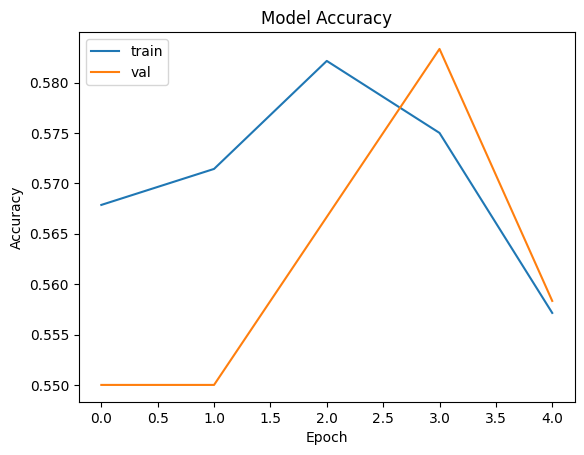

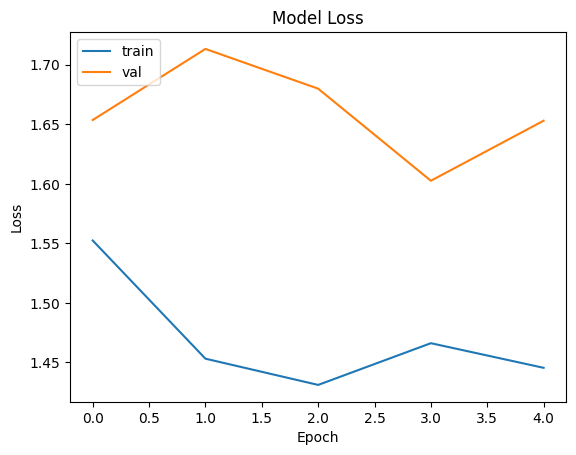

In [27]:

# Plot the training and validation accuracy
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [28]:

# Train the model
history_5 = model_1.fit(
    train_generator,
    epochs=5,  # specify the number of epochs for training
    validation_data=val_generator
)


Epoch 1/5
5/5 [==============================] - 313s 65s/step - loss: 1.2960 - accuracy: 0.5964 - val_loss: 1.5460 - val_accuracy: 0.6167
Epoch 2/5
5/5 [==============================] - 362s 78s/step - loss: 1.3594 - accuracy: 0.6036 - val_loss: 1.6053 - val_accuracy: 0.5500
Epoch 3/5
5/5 [==============================] - 368s 79s/step - loss: 1.3829 - accuracy: 0.5893 - val_loss: 1.5072 - val_accuracy: 0.6000
Epoch 4/5
5/5 [==============================] - 363s 78s/step - loss: 1.3735 - accuracy: 0.5857 - val_loss: 1.4925 - val_accuracy: 0.6083
Epoch 5/5
5/5 [==============================] - 364s 78s/step - loss: 1.2575 - accuracy: 0.6036 - val_loss: 1.3278 - val_accuracy: 0.6917


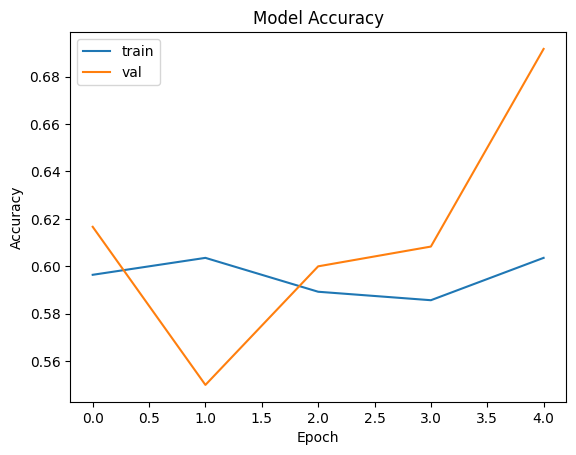

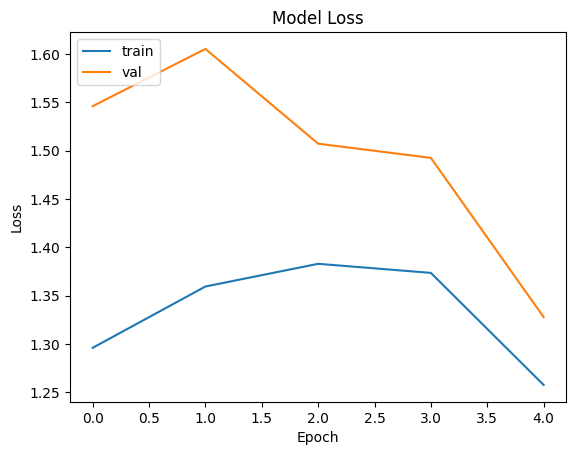

In [29]:

# Plot the training and validation accuracy
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [30]:
model_1.save_weights('model_1_weights_updated1.h5')

In [14]:
# Load the model from the H5 file
model_1.load_weights('/content/model_1_weights_updated1.h5')

In [15]:

# Train the model
history_6 = model_1.fit(
    train_generator,
    epochs=5,  # specify the number of epochs for training
    validation_data=val_generator
)


Epoch 1/5
5/5 [==============================] - 366s 78s/step - loss: 1.6242 - accuracy: 0.4786 - val_loss: 1.4650 - val_accuracy: 0.5583
Epoch 2/5
5/5 [==============================] - 358s 85s/step - loss: 1.3742 - accuracy: 0.5964 - val_loss: 2.0861 - val_accuracy: 0.4333
Epoch 3/5
5/5 [==============================] - 362s 78s/step - loss: 1.3220 - accuracy: 0.6286 - val_loss: 1.3104 - val_accuracy: 0.6833
Epoch 4/5
5/5 [==============================] - 359s 77s/step - loss: 1.2373 - accuracy: 0.6429 - val_loss: 1.4124 - val_accuracy: 0.6250
Epoch 5/5
5/5 [==============================] - 363s 78s/step - loss: 1.2180 - accuracy: 0.6179 - val_loss: 1.5427 - val_accuracy: 0.6500


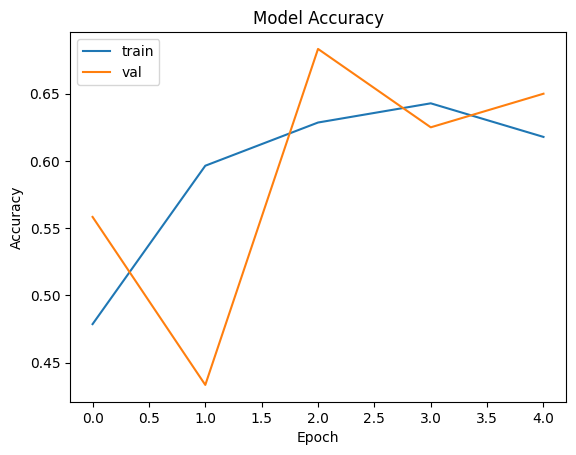

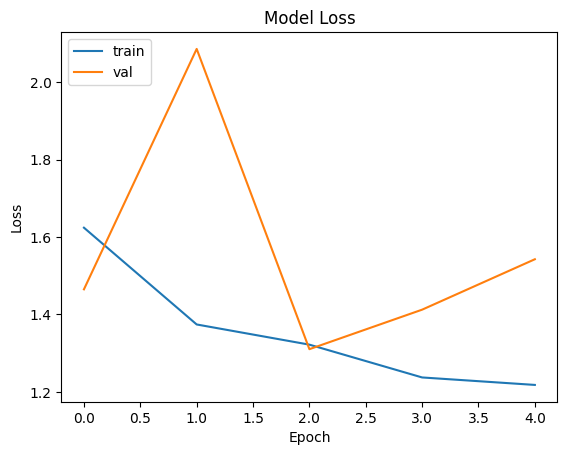

In [16]:

# Plot the training and validation accuracy
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [17]:

# Train the model
history_7 = model_1.fit(
    train_generator,
    epochs=5,  # specify the number of epochs for training
    validation_data=val_generator
)


Epoch 1/5
5/5 [==============================] - 309s 64s/step - loss: 1.1482 - accuracy: 0.6464 - val_loss: 1.3123 - val_accuracy: 0.6667
Epoch 2/5
5/5 [==============================] - 360s 85s/step - loss: 1.0459 - accuracy: 0.6857 - val_loss: 1.3222 - val_accuracy: 0.6333
Epoch 3/5
5/5 [==============================] - 357s 77s/step - loss: 1.1404 - accuracy: 0.6321 - val_loss: 1.3875 - val_accuracy: 0.7167
Epoch 4/5
5/5 [==============================] - 359s 77s/step - loss: 1.0824 - accuracy: 0.6750 - val_loss: 1.2328 - val_accuracy: 0.6750
Epoch 5/5
5/5 [==============================] - 360s 77s/step - loss: 1.1323 - accuracy: 0.6536 - val_loss: 1.4564 - val_accuracy: 0.6333


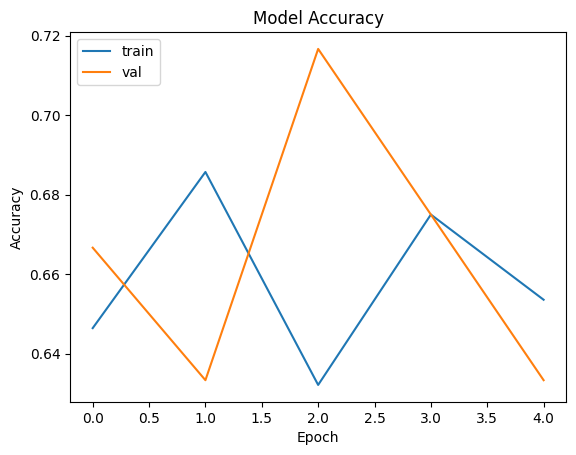

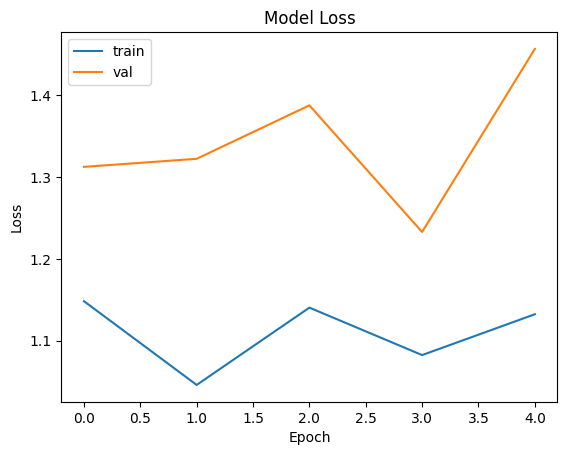

In [18]:

# Plot the training and validation accuracy
plt.plot(history_7.history['accuracy'])
plt.plot(history_7.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [19]:

# Train the model
history_8 = model_1.fit(
    train_generator,
    epochs=5,  # specify the number of epochs for training
    validation_data=val_generator
)


Epoch 1/5
5/5 [==============================] - 309s 64s/step - loss: 1.0874 - accuracy: 0.6643 - val_loss: 1.2747 - val_accuracy: 0.7583
Epoch 2/5
5/5 [==============================] - 360s 77s/step - loss: 1.0315 - accuracy: 0.6893 - val_loss: 1.3119 - val_accuracy: 0.6583
Epoch 3/5
5/5 [==============================] - 308s 65s/step - loss: 0.9674 - accuracy: 0.7250 - val_loss: 1.3164 - val_accuracy: 0.7000
Epoch 4/5
5/5 [==============================] - 360s 77s/step - loss: 0.9725 - accuracy: 0.7107 - val_loss: 1.2383 - val_accuracy: 0.6667
Epoch 5/5
5/5 [==============================] - 359s 77s/step - loss: 1.0159 - accuracy: 0.7000 - val_loss: 1.2898 - val_accuracy: 0.7333


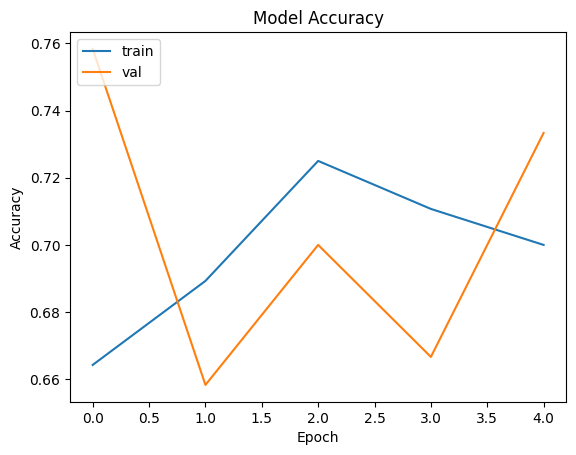

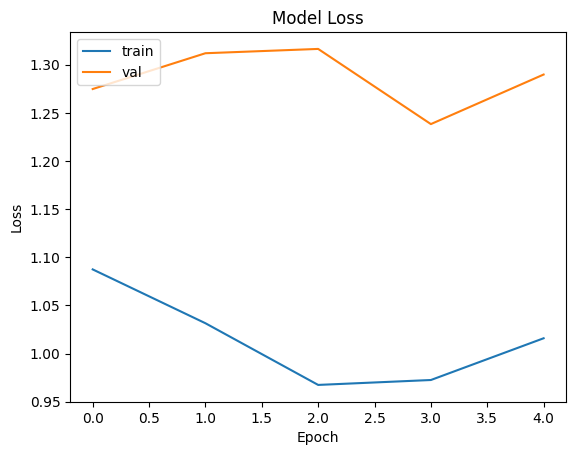

In [20]:

# Plot the training and validation accuracy
plt.plot(history_8.history['accuracy'])
plt.plot(history_8.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_8.history['loss'])
plt.plot(history_8.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [22]:

# Train the model
history_9 = model_1.fit(
    train_generator,
    epochs=5,  # specify the number of epochs for training
    validation_data=val_generator
)


Epoch 1/5
5/5 [==============================] - 310s 64s/step - loss: 0.9819 - accuracy: 0.7286 - val_loss: 1.3294 - val_accuracy: 0.7333
Epoch 2/5
5/5 [==============================] - 360s 77s/step - loss: 0.9764 - accuracy: 0.6536 - val_loss: 1.3188 - val_accuracy: 0.6333
Epoch 3/5
5/5 [==============================] - 362s 78s/step - loss: 1.0145 - accuracy: 0.6536 - val_loss: 1.2271 - val_accuracy: 0.7000
Epoch 4/5
5/5 [==============================] - 366s 79s/step - loss: 0.9580 - accuracy: 0.6929 - val_loss: 1.2082 - val_accuracy: 0.7500
Epoch 5/5
5/5 [==============================] - 360s 77s/step - loss: 0.9055 - accuracy: 0.7250 - val_loss: 1.1770 - val_accuracy: 0.7333


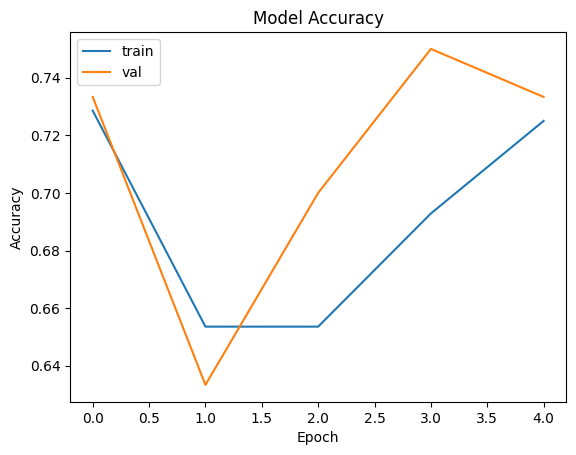

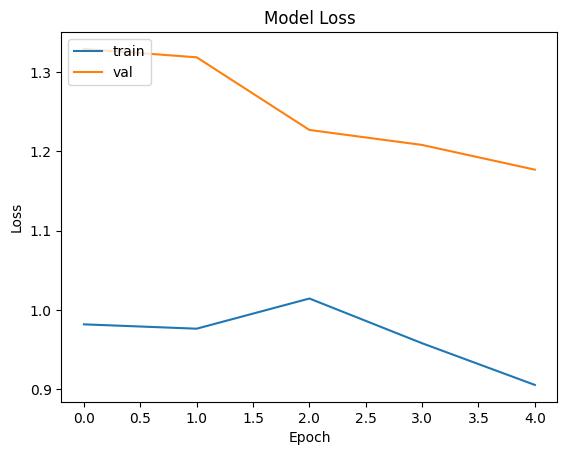

In [23]:

# Plot the training and validation accuracy
plt.plot(history_9.history['accuracy'])
plt.plot(history_9.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_9.history['loss'])
plt.plot(history_9.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [24]:

# Train the model
history_10 = model_1.fit(
    train_generator,
    epochs=5,  # specify the number of epochs for training
    validation_data=val_generator
)


Epoch 1/5
5/5 [==============================] - 360s 85s/step - loss: 0.9062 - accuracy: 0.6964 - val_loss: 1.2755 - val_accuracy: 0.7083
Epoch 2/5
5/5 [==============================] - 310s 72s/step - loss: 0.8877 - accuracy: 0.7214 - val_loss: 1.1185 - val_accuracy: 0.7500
Epoch 3/5
5/5 [==============================] - 366s 86s/step - loss: 0.9904 - accuracy: 0.6929 - val_loss: 1.0925 - val_accuracy: 0.7500
Epoch 4/5
5/5 [==============================] - 360s 85s/step - loss: 0.8906 - accuracy: 0.7429 - val_loss: 1.1829 - val_accuracy: 0.7167
Epoch 5/5
5/5 [==============================] - 367s 79s/step - loss: 0.7985 - accuracy: 0.7143 - val_loss: 1.0729 - val_accuracy: 0.7167


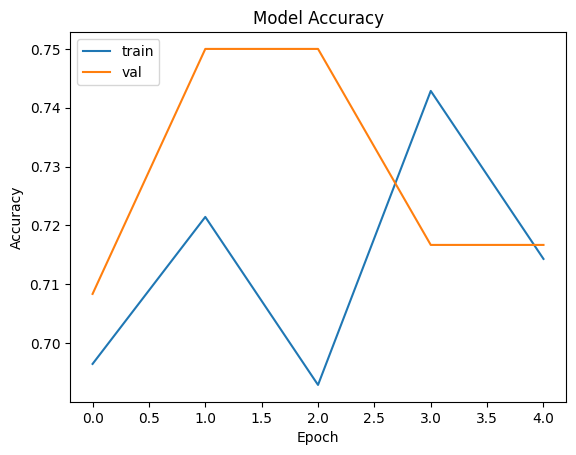

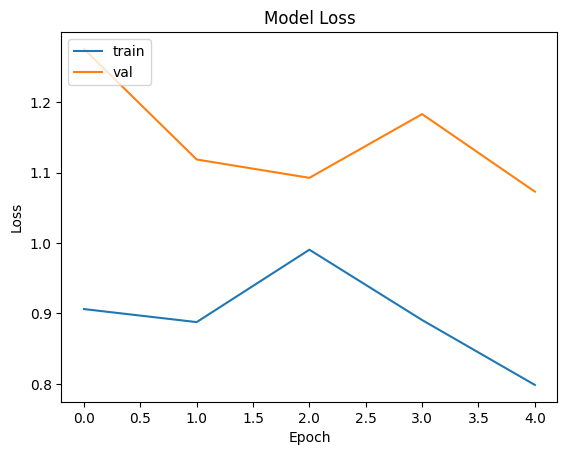

In [25]:

# Plot the training and validation accuracy
plt.plot(history_10.history['accuracy'])
plt.plot(history_10.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_10.history['loss'])
plt.plot(history_10.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [26]:
model_1.save_weights('model_1_weights_updated2.h5')

In [27]:
model_1.save('model_1_updated2.h5')

In [6]:
# Load the model from the H5 file
model_1.load_weights('/content/model_1_weights_updated2.h5')

In [7]:

# Create a new model that outputs the fc7 features
fc7_layer = model_1.get_layer('dense_1')
fc7_output = fc7_layer.output
model_2 = Model(inputs=model_1.input, outputs=fc7_output)


In [92]:
# Load and preprocess an input image
img = image.load_img('/content/process_data/valid/s1/10.png', target_size=(227, 227))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract features using the fc7 model
features = model_2.predict(x)
print(features)


1/1 [==============================] - 1s 1s/step
[[0.        0.        0.        ... 0.        0.        7.8227334]]


In [93]:

# Define the paths to the validation dataset
validation_dir = '/content/process_data/valid'

# Define the batch size for validation data
batch_size = 1

# Get the list of validation image directories
validation_directories = [os.path.join(validation_dir, folder_name) for folder_name in os.listdir(validation_dir)]

# Create an empty list to hold the feature vectors for the validation images
validation_features = []

# Loop through the validation image directories
for validation_directory in validation_directories:
    # Create an empty list to hold the feature vectors for the validation images in the current directory
    directory_features = []
    
    # Loop through the validation images in the current directory
    for i in range(8, 11):
        # Load the validation image using PIL
        img_path = os.path.join(validation_directory, f'{i}.png')
        img = image.load_img(img_path, target_size=(227, 227))
        
        # Convert the image to a numpy array and preprocess it
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        # Extract the features using the VGG19 model
        features = model_2.predict(x)
        
        # Add the features to the list of features for the current directory
        directory_features.append(features.flatten())
    
    # Convert the list of features for the current directory to a numpy array
    directory_features = np.array(directory_features)
    
    # Add the numpy array to the list of feature vectors for all validation images
    validation_features.append(directory_features)

# Convert the list of feature vectors for all validation images to a numpy array
validation_features = np.array(validation_features)


1/1 [==============================] - 1s 702ms/step


In [98]:

# Create a list for enrollment features for all subjects
enrollment_features = [[0] * 4096 for i in range(40)]

# Create a list for verification features for all subjects and each verification image
verification_features = [[[0] * 4096 for k in range(2)] for j in range(40)]

# Populate the enrollment_features list
for i in range(0,40):
    enrollment_features[i] = validation_features[i][0]

# Populate the verification_features list
for j in range(0,40):
    verification_features[j][0] = validation_features[j][1]
    verification_features[j][1] = validation_features[j][2]

# Create a numpy array to store the cosine similarities
cosine_similarities = np.zeros((3200, 2))

# Iterate over each person and their enrollment and verification images
for i in range(0,40):
    a = 80 * i
    for j in range(0,40):
        b = a + (2 * j)
        c = b + 1
        # Get the enrollment feature and the two verification features
        enrollment_features_2d = enrollment_features[i].reshape(1, -1)
        verification_features_1_2d = verification_features[j][0].reshape(1, -1)
        verification_features_2_2d = verification_features[j][1].reshape(1, -1)
        # Calculate the cosine similarity between the enrollment and verification features
        cosine_similarities[b][0] = cosine_similarity(enrollment_features_2d, verification_features_1_2d)
        cosine_similarities[c][0] = cosine_similarity(enrollment_features_2d, verification_features_2_2d)
        # Set the cosine similarity to 1 if the enrollment and verification images are from the same person
        if i == j:
            cosine_similarities[b][1] = 1
            cosine_similarities[c][1] = 1

print(cosine_similarities)


[[0.98855329 1.        ]
 [0.99156564 1.        ]
 [0.9804852  0.        ]
 ...
 [0.97409797 0.        ]
 [0.97108161 1.        ]
 [0.97487926 1.        ]]


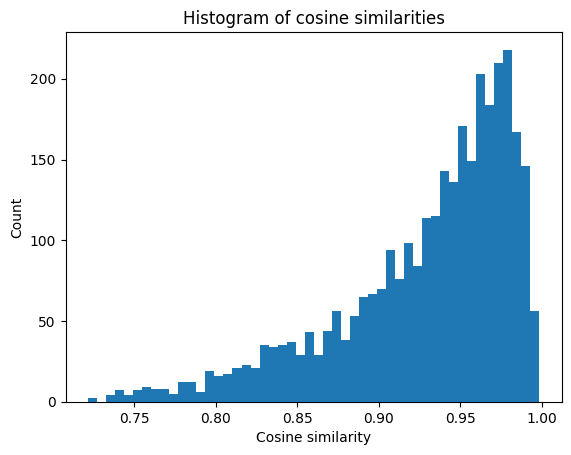

In [105]:

# Transpose and extract all cosine similarities
cosine_similarities_t = np.transpose(cosine_similarities)
cosine_similarities_raw = cosine_similarities_t[0]

# Plot the histogram
plt.hist(cosine_similarities_raw, bins=50)
plt.xlabel('Cosine similarity')
plt.ylabel('Count')
plt.title('Histogram of cosine similarities')
plt.show()


In [106]:

# Create emply list for genuine and imposter scores
genuine_scores = []
imposter_scores = []

# Populate the lists based on true labels provided
for i in range(cosine_similarities.shape[0]):
    if cosine_similarities[i][1] == 1:
        genuine_scores.append(cosine_similarities[i][0])
    else:
        imposter_scores.append(cosine_similarities[i][0])


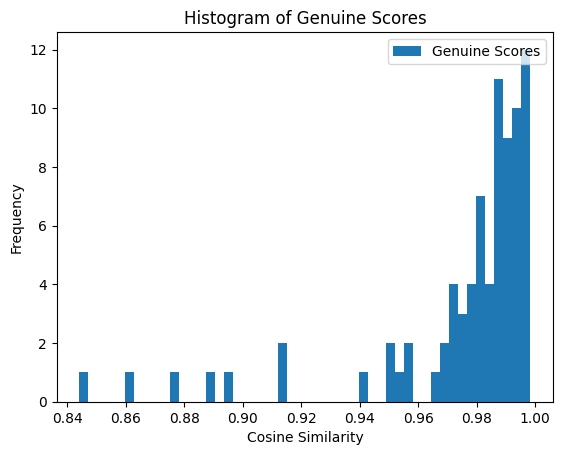

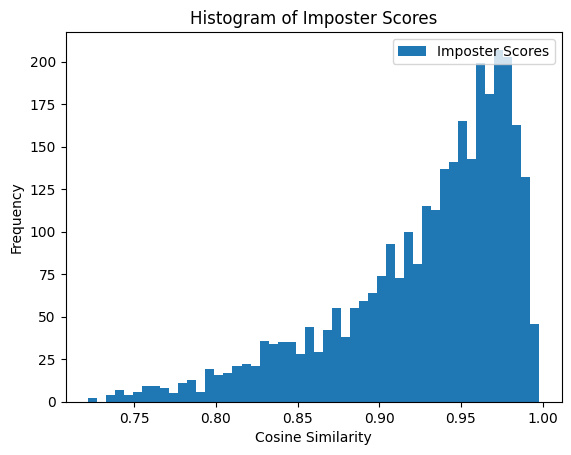

In [110]:

# Plot histogram for genuine_scores
plt.hist(genuine_scores, bins=50, label='Genuine Scores')
plt.title('Histogram of Genuine Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Plot histogram for imposter_scores
plt.hist(imposter_scores, bins=50, label='Imposter Scores')
plt.title('Histogram of Imposter Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


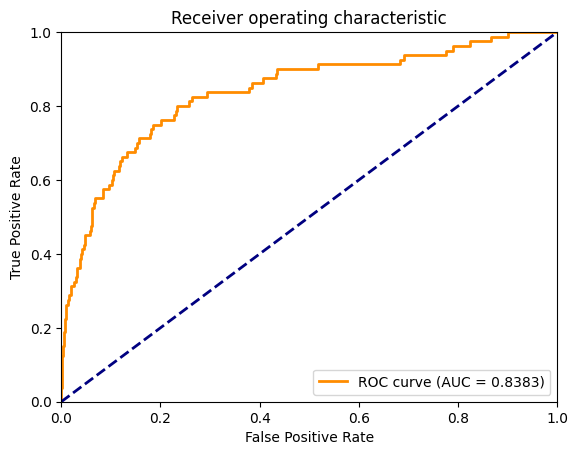

In [115]:

# create arrays to store true labels and similarity scores
true_labels = cosine_similarities_t[1]
scores = cosine_similarities_t[0]

# create arrays to store FPR and TPR for different thresholds
fpr = []
tpr = []
thresholds = []

# calculate the FPR and TPR for different thresholds
fpr, tpr, thresholds = roc_curve(true_labels, scores)

# calculate the area under the ROC curve (AUC)
auc_score = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
